# Хакатон "Геомодель" задача 2





Решение команды (а точнее *solo*) FasterThanHammer  
Мария Смирнова / [@SmirnovaMariaD](t.me/SmirnovaMariaD)    
**В этой тетрадке выберем архитектуру модели для финального обучения**  
Тетрадка с финальной моделью [github](https://github.com/SlateFlegg/Geomodel_hack/blob/main/FTH_final_notebook.ipynb)  
Тетрадка с анализом данных [github](https://github.com/SlateFlegg/Geomodel_hack/blob/main/Analisys.ipynb)

## Summary

**Выбранная модель**  
В результате экспериментов была выбрана модель `CoordsModUnet` домонтрировшая хороший результат как по метрике, так и по визуальному контролю    
*Два примера результата предобучения на 30 эпохах:*  
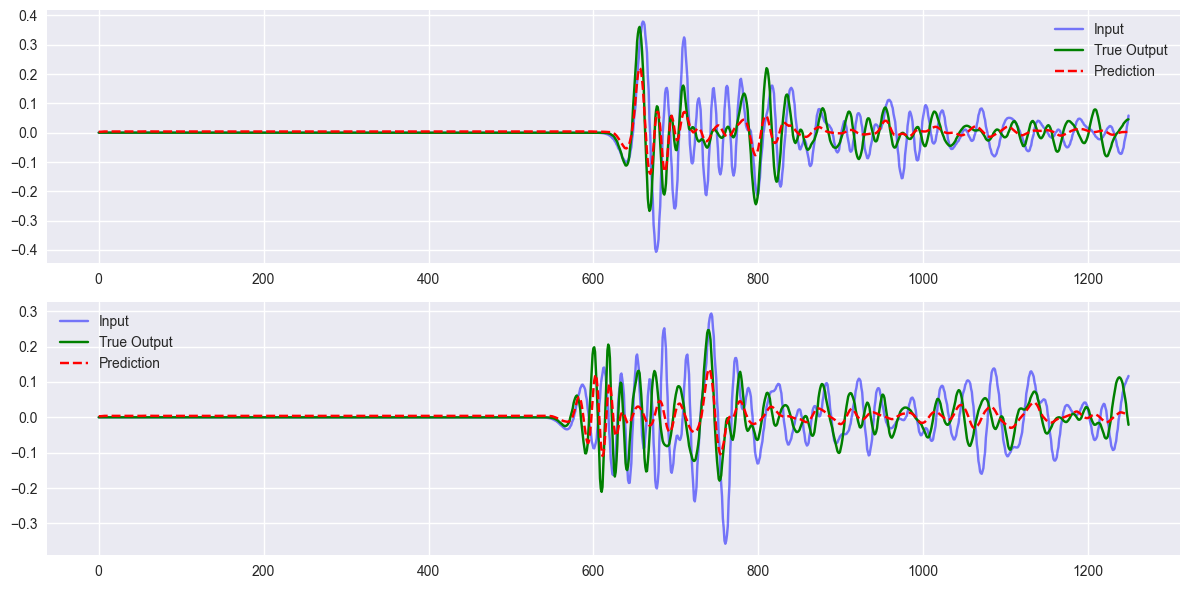

**Общие замечания**:    
Подходить к решению задачи можно несколькими способами, классическим - через свёртки и вариации CNN, как к задачи апскейлинга, с добавлением расстояния и/или положения сенсора. В основном, в таких случаях применяются Unet-подобные модели, с нескольмими этапами свёртки и skip-connections.  
* Всего 2016 сенсоров, однако для каждого сенсора есть 6 тензоров, а также 3 канала  
* Главная метрика MAE для всего спектра во временной области, поэтому ориентироватся на отдельные частоты не обязательно. Более того, из аналитической тетрадки видно, что наибольшую раницу между 9м и 14м-моделированием задают частоты: от 0 до 20 и от 20 до 40. А также стоит помнить, что МАЕ неусточива к фазе, неустойчика к сдвигу, а работа во временном пространстве не выловит разницу в частотном составе      
* Важно вносить положение сенсоров - иначе модель может искать не "приближенные" к каждому сенсору данные, а нечто среднее между всеми показателями сенсоров при этом теряя физический смысл сейсмики.  
* Сами по себе данные достаточно схожи, нужно защищаться от переобучения шумом, dropout'ами или skip-connections чтобы не потерять значимую физическую информацию   
* Увеличение количество сенсоров ведёт к необратимому росту ошибки. Возможно, обучение секторами может дать дополнительное качество (но в данном решении не реализовано)  

**Рассмотренные модели**    
*Для отбора моделей параметры: `selected_sensors_num`=2016, `batch_size`=32, `epochs`=30*   
1) `Dummy`: `0.045832` Примерная оценка МАЕ в случае если бы мы просто использовали 14м-данные. Эта оценка нужна, чтобы иметь представление о качесве работы моделей, она позволяет оценить качество сверху. Очевидно, что тоже мы будем наблюдать и при преобразование Фурье "посередине"    
2) `Baseline model` - она представляет собой классическую Unet модель, в которой не учитываются расстояние и положение сенсоров. Бейзлайн на всех сенсорах и 300 эпохах показывает хороший результат: `0.022763`. Почти в двое лучше `dummy`. Для первичного отбора моделей также посмотрим на обучение на 30 эпохах и для 2016 сенсорах - `0.024654`      
На графике Loss-epochs сразу видна характерная черта Unet-подбных моделей - существенные скачки как train, так и validation loss, которые в том числе могут так себя вести из-за разных пород.  

*График для baseline, batch_size=32, all sensors, 300 epochs.*   
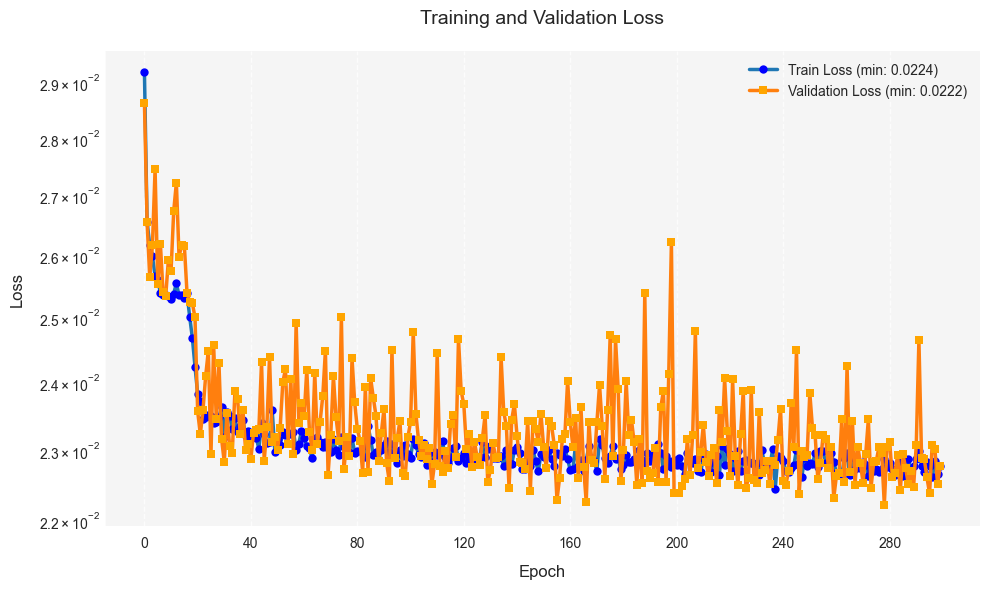  

### Эксперименты с моделями  
1) `FTHUnet` - создаём новый класс данных, который будет включать в себя расстояния. Сначала проверим, как вообще включение расстояний влияет на метрики. Для быстрой провекри выберём только 1000 сенсоров и небольшое количество эпох. В данной модели расстояния учитываются с помощью двух линейных слоёв и функцией активации `ReLu`. Метрика: `0.024821`. В целом, происходит ожидаемое падение метрики, однако не сильно - вероятно это правильный путь.
2) Развивая эту идею пишем простую модель, без skip-connections, но с большей устойчивостью к переобучению: `SimpleModel`, задача понять нужно ли отходить от идеи со skip-connections, возможно они могут привносить слишком много артефактов из 14м-модели: MAE: `0.027044`     
3) `CNN_LSTM` Отдельной идей посмотреть на эти данные как time-series. В частности включить `LSTM` подходы. А также "обрезку" по определённому значению частоты, чтобы учесть только "информативные участки". Это самая вычислительносложная модель. `0.027984` 
4) `GNN` - модель свёртки на графах. Результат на отборе: `0.024495`.Это можель считает сразу все каналы и тензоры, возможность настройки гиперпарамтера радиуса учёта датчиков. В модели два модуля: свертка на графах, которая распространяет признаки узлов через структуру графа и distance-processing.   
Может выглядеть, что distance-processing избыточен (ведь в графе уже учтены расстояния между сенсорами), однако задача этой части преобразовывать расстояния в "веся влияния".   
5) `ModUnet` - модификация Unet с большим числом блоков кодирования-декодирования, skip-connections и, что самое важное, с увеличенными свёртками (kernel_size=7). Результат на отборе: `0.019860`. Это модель вдохновлена работой: [github:SeismicPro](https://github.com/learnserd/SeismicPro/blob/master/tutorials/4.Models.ipynb)    
6) `CoordModNet` - главное отличие от предыдущей сетки это включение учёт координат, а не только расстояний.


## Загрузки и настройки

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torch_geometric.loader import DataLoader as geoDataLoader
import torch.optim as optim
import numpy as np
import os
import h5py
import re
import matplotlib.pyplot as plt
import numpy as np
from scipy.fft import fft, fftfreq
import geopandas as gpd
import pandas as pd
from matplotlib.ticker import MaxNLocator
from tqdm.auto import tqdm
import datetime

import baseline_net as bs_net # Unet з бейзлайна
import baseline_dataset as bs_dataset
import FTH.unet
import FTH_dataset
import FTH_coords_dataset
import FTH.SimpleModel
import FTH.GNN
import FTH.FFCNN_LSTM
import FTH.ModUnet
import FTH.CoordsModUnet

In [3]:
#path=r'/content/drive/MyDrive/Task2/data/'

file_path_9 = r"data\9m\batch_9m.hdf5"
file_path_14 = r"data\14m\batch_14m.hdf5"
file_points_data_path = r'data\points_data.txt'
file_sensors_data_path = r'data\sensors_data.txt'


path = r'data\\'
file_path_14 = path+r'14m/batch_14m.hdf5'
file_path_9 = path+r'9m/batch_9m.hdf5'
file_sensors_data_path = path+'sensors_data.txt'
file_points_data_path = path+'points_data.txt'

#baseline model
path = r'data\\'
path_to_input_batch = path+r'14m/batch_14m.hdf5'
path_to_output_batch = path+r'9m/batch_9m.hdf5'

# path to save model's weights
saving_path = r'models_weights'

# для таблицы сравнения моделей
df_path = r''

**Настрока параметров модели и данных**   
Из-за вычислительных ограничений для каждого канала будет своя модель - такой простой способ реализации ансамбля

In [4]:
channels = ['Z']  # например, для обучения берем канал Z, все каналы доступны через ['Z','X','Y']
train_fraction = 0.8  # доля сэмплов для обучения
selected_sensors_num = 2016 #  для быстрого запуска берем 10 сенсоров (в задаче необходимо использовать все сенсоры)
batch_size = 32
epochs = 30
learning_rate = 0.01
num_sources_points = [0,1] # номера точек ударов

**Считываем метаданные точек**     
Расчитываем расстояние от точки удара до каждого сенсора, записываем в `df`  
В идеале, эти данные нужно обрабатывать в классе - но пок мы точно не знаем какие пространственные данные и в каком виде потребуеются

In [5]:
with open(file_sensors_data_path) as f:
    sensors_data = [line.split() for line in f]
sensors_names = [str(sub[0]) for sub in sensors_data]

points_data = []
with open(file_points_data_path) as f:
    points_data = ([line.split() for line in f])


df = gpd.GeoDataFrame(sensors_data, columns=(['sensor_name', 'x', 'y', 'z']))
df = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['x'], df['y'], df['z']))
df_impact = gpd.GeoDataFrame(points_data, columns=(['sensor_name', 'x', 'y', 'z']))
df_impact = gpd.GeoDataFrame(df_impact, geometry=gpd.points_from_xy(df_impact['x'], df_impact['y'], df_impact['z']))

for _, impact_point in df_impact.iterrows():
    impact_name = impact_point['sensor_name']
    distances = df.geometry.distance(impact_point.geometry)
    df[f'dist_to_{impact_name}'] = distances

df.sample(3)

,sensor_name,x,y,z,geometry,dist_to_p1,dist_to_p2
67,68,1683827.62,6649207.23,0,POINT Z (1683827.62 6649207.23 0),4795.543680,4681.906576
1085,1086,1688027.62,6651207.23,0,POINT Z (1688027.62 6651207.23 0),787.174177,1242.035903
1322,1323,1689027.62,6650607.23,0,POINT Z (1689027.62 6650607.23 0),596.197270,823.687553


`plot_teaching` - функция для визуалзации уменьшения loss в процессе обучения

In [6]:
def plot_teaching(train_loss: list, val_loss: list, epochs: int):
    # Создаем фигуру с настроенным размером
    plt.figure(figsize=(10, 6), dpi=100)

    plt.style.use('seaborn-v0_8')
    
    # Рисуем кривые обучения
    plt.plot(train_loss, 
             label=f'Train Loss (min: {min(train_loss):.4f})',
             linewidth=2.5,
             color='#1f77b4',
             marker='o',
             markersize=6,
             markeredgecolor='black',
             markerfacecolor='blue')
    
    plt.plot(val_loss, 
             label=f'Validation Loss (min: {min(val_loss):.4f})',
             linewidth=2.5,
             color='#ff7f0e',
             marker='s',
             markersize=6,
             markeredgecolor='black',
             markerfacecolor='orange')
    
    # Настройка осей и сетки
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))  # Только целые значения на оси X
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xlabel('Epoch', fontsize=12, labelpad=10)
    plt.ylabel('Loss', fontsize=12, labelpad=10)
    plt.title('Training and Validation Loss', fontsize=14, pad=20)
    
    # Легенда
    plt.legend(fontsize=10, framealpha=1, shadow=True)
    
    # Улучшенные границы
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['left'].set_linewidth(0.5)
    plt.gca().spines['bottom'].set_linewidth(0.5)
    
    # Фон
    plt.gca().set_facecolor('#f5f5f5')
    plt.gcf().set_facecolor('white')
    
    # Логарифмическая шкала
    plt.yscale('log')
    plt.tight_layout()
    plt.show()

`model_comparison` - датафрем, в который будут записаны результаты обучения моделей, для выбора лучшей.  
Функция `highlight_rows` подсвечивает актуальную модель

In [7]:
df_path = r''
model_comparison_path = os.path.join(df_path, "model_comparison.csv")
   
if os.path.exists(model_comparison_path):
    print(f"Loading existing model comparison from {model_comparison_path}")
    try:
        model_comparison = pd.read_csv(model_comparison_path)
    except Exception as e:
        print(f"Error loading file, creating new one. Error: {e}")
        model_comparison = pd.DataFrame(columns=['model', 'val_loss', 'train_loss', 'best_val_loss', 'best_train_loss', 'epochs', 'sensors_num', 'datetime'])        
else:
    print(f"No existing model comparison found at {model_comparison_path}, creating new one")
    model_comparison = pd.DataFrame(columns=['model', 'val_loss', 'train_loss', 'best_val_loss', 'best_train_loss', 'epochs', 'sensors_num', 'datetime'])


def highlight_rows(row, model_name):
    color = 'background-color: yellow' if row['model'] == model_name else ''
    return [color] * len(row)

No existing model comparison found at model_comparison.csv, creating new one


## Обучение моделей

Создадим условный пайплайн для моделей  
`plot_predictions` - для отрисовки примеров работ моделей (input, true output, predicted)    
`prapere_and_train_model` - условный пайп-лайн тренировки для некоторых моделей

In [ ]:
def plot_predictions(model, dataloader, device, num_samples=3):
        model.eval()
        fig, axes = plt.subplots(num_samples, 1, figsize=(12, 3*num_samples))
        if num_samples == 1:
            axes = [axes]
            
        with torch.no_grad():
            try:
                for inputs, targets, distances in dataloader:
                    inputs = inputs.float().to(device)
                    distances = distances.float().to(device)
                    preds = model(inputs, distances).cpu().numpy()
                    
                    inputs = inputs.cpu().numpy()
                    targets = targets.cpu().numpy()
                    
                    for i in range(min(num_samples, inputs.shape[0])):
                        ax = axes[i]
                        time = np.arange(inputs.shape[2])
                        
                        ax.plot(time, inputs[i][0], 'b-', alpha=0.5, label='Input')
                        ax.plot(time, targets[i][0], 'g-', label='True Output')
                        ax.plot(time, preds[i][0], 'r--', label='Prediction')
                        
                        ax.legend()
                        ax.grid(True)
                    
                    if i >= num_samples-1:
                        break
            except:
                 for inputs, targets in dataloader:
                    inputs = inputs.float().to(device)
                    preds = model(inputs).cpu().numpy()
                    
                    inputs = inputs.cpu().numpy()
                    targets = targets.cpu().numpy()
                    
                    for i in range(min(num_samples, inputs.shape[0])):
                        ax = axes[i]
                        time = np.arange(inputs.shape[2])
                        
                        ax.plot(time, inputs[i][0], 'b-', alpha=0.5, label='Input')
                        ax.plot(time, targets[i][0], 'g-', label='True Output')
                        ax.plot(time, preds[i][0], 'r--', label='Prediction')
                        
                        ax.legend()
                        ax.grid(True)
                    
                    if i >= num_samples-1:
                        break
                    
        plt.tight_layout()
        plt.show()

In [9]:
def prapere_and_train_model(model_name, data, model_class, model_comparison):
    model = model_class()

    train_size = int(train_fraction * len(data))
    val_size = len(data) - train_size
    train_data, val_data = random_split(data, [train_size, val_size])

    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    criterion = nn.L1Loss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_loss = []
    val_loss = []
    for epoch in tqdm(range(epochs), desc='Training'):

        batch_train_loss = []
        batch_val_loss = []

        model.train()
        for inputs, output, distances in train_dataloader:
            inputs = inputs.float().to(device)
            output = output.float().to(device)
            distances = distances.float().to(device)

            predicted_output = model(inputs, distances)
            loss = criterion(predicted_output, output)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_train_loss.append(loss.item())

        train_loss.append(np.mean(batch_train_loss))

        model.eval()
        for inputs, output, distances in val_dataloader:
            inputs = inputs.float().to(device)
            output = output.float().to(device)
            distances = distances.float().to(device)
            predicted_output = model(inputs, distances)
            loss = criterion(predicted_output, output)

            batch_val_loss.append(loss.item())

        val_loss.append(np.mean(batch_val_loss))

        #print(f'epoch {epoch}, train_loss {np.mean(batch_train_loss)}, val_loss {np.mean(batch_val_loss)}')    # После завершения обучения:
    
    
    # Визуализируем примеры из валидационного набора
    plot_predictions(model, val_dataloader, device, num_samples=2)



    plot_teaching(train_loss, val_loss, len(train_loss))
    time = datetime.datetime.now().strftime("%m/%d/%Y, %H:%M:%S")
    new_row = [model_name, np.mean(batch_val_loss), np.mean(batch_train_loss), 
               min(val_loss), min(train_loss), epochs, selected_sensors_num, time]
    model_comparison = pd.concat([model_comparison, pd.DataFrame([new_row], columns=model_comparison.columns)], ignore_index=True)
    styled = model_comparison.style.apply(highlight_rows, args=(model_name,), axis=1)
    display(styled)
    model_comparison.to_csv(model_comparison_path, index=False)
    return model_comparison, model

### Dummy model

Для опорной точки качества выберем MAE между 14м и 9м данными. Метрика: `0.045832`.

In [10]:
model_name = 'dummy_model'

data = bs_dataset.MicroseismDataset(input_batch=path_to_input_batch,
                                    output_batch=path_to_output_batch,
                                    selected_sensors_names=sensors_names[:selected_sensors_num],
                                    number_sources_points = num_sources_points,
                                    sensors_names=sensors_names,
                                    channels=channels)

dummy_loss = []
batch_dummy_loss = []

criterion = nn.L1Loss()
data = DataLoader(data, batch_size=batch_size, shuffle=False)

for input, output in data:
    
    loss = criterion(input, output)
    batch_dummy_loss.append(loss.item())
dummy_loss = np.mean(batch_dummy_loss)


new_row = [model_name, np.mean(batch_dummy_loss), np.mean(batch_dummy_loss), dummy_loss, dummy_loss, epochs, selected_sensors_num, datetime.datetime.now().strftime("%m/%d/%Y, %H:%M:%S")]
model_comparison = pd.concat([model_comparison, pd.DataFrame([new_row], columns=model_comparison.columns)], ignore_index=True)
styled = model_comparison.style.apply(highlight_rows, args=(model_name,), axis=1)
display(styled)


C:\Users\Maria\AppData\Local\Temp\ipykernel_26364\240462573.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_comparison = pd.concat([model_comparison, pd.DataFrame([new_row], columns=model_comparison.columns)], ignore_index=True)


,model,val_loss,train_loss,best_val_loss,best_train_loss,epochs,sensors_num,datetime
0,dummy_model,0.045832,0.045832,0.045832,0.045832,30,2016,"05/14/2025, 02:43:43"


In [11]:
model_name = 'dummy_model_Fourier'

data = bs_dataset.MicroseismDataset(input_batch=path_to_input_batch,
                                    output_batch=path_to_output_batch,
                                    selected_sensors_names=sensors_names[:selected_sensors_num],
                                    number_sources_points = num_sources_points,
                                    sensors_names=sensors_names,
                                    channels=channels)


class FFTAugmentedModel(nn.Module):
    def __init__(self):
        super(FFTAugmentedModel, self).__init__()
        
    def forward(self, x):
        x_fft = torch.fft.fft(x, dim=-1)        
        # 3. Convert back to time domain
        x_processed = torch.fft.ifft(x_fft, dim=-1).real
        return x_processed

model = FFTAugmentedModel()
criterion = nn.L1Loss()
data = DataLoader(data, batch_size=batch_size, shuffle=False)

batch_dummy_loss = []
for input, output in data:
    
    #input = input.float()
    #output = output.float()
    processed_input = model(input)

    loss = criterion(processed_input, output)
    batch_dummy_loss.append(loss.item())
dummy_loss = np.mean(batch_dummy_loss)


new_row = [model_name, np.mean(batch_dummy_loss), np.mean(batch_dummy_loss), dummy_loss, dummy_loss, epochs, selected_sensors_num, datetime.datetime.now().strftime("%m/%d/%Y, %H:%M:%S")]
model_comparison = pd.concat([model_comparison, pd.DataFrame([new_row], columns=model_comparison.columns)], ignore_index=True)
styled = model_comparison.style.apply(highlight_rows, args=(model_name,), axis=1)
display(styled)

,model,val_loss,train_loss,best_val_loss,best_train_loss,epochs,sensors_num,datetime
0,dummy_model,0.045832,0.045832,0.045832,0.045832,30,2016,"05/14/2025, 02:43:43"
1,dummy_model_Fourier,0.045832,0.045832,0.045832,0.045832,30,2016,"05/14/2025, 02:43:47"


### Baseline model

Бейзлайн модель - классический unet

In [12]:
model_name = 'baseline_unet'

data = bs_dataset.MicroseismDataset(input_batch=path_to_input_batch,
                                    output_batch=path_to_output_batch,
                                    selected_sensors_names=sensors_names[:selected_sensors_num],
                                    number_sources_points = num_sources_points,
                                    sensors_names=sensors_names,
                                    channels=channels)

train_size = int(train_fraction * len(data))
val_size = len(data) - train_size
train_data, val_data = random_split(data, [train_size, val_size])

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = bs_net.Unet()
model.to(device)

criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Training:   0%|          | 0/30 [00:00<?, ?it/s]

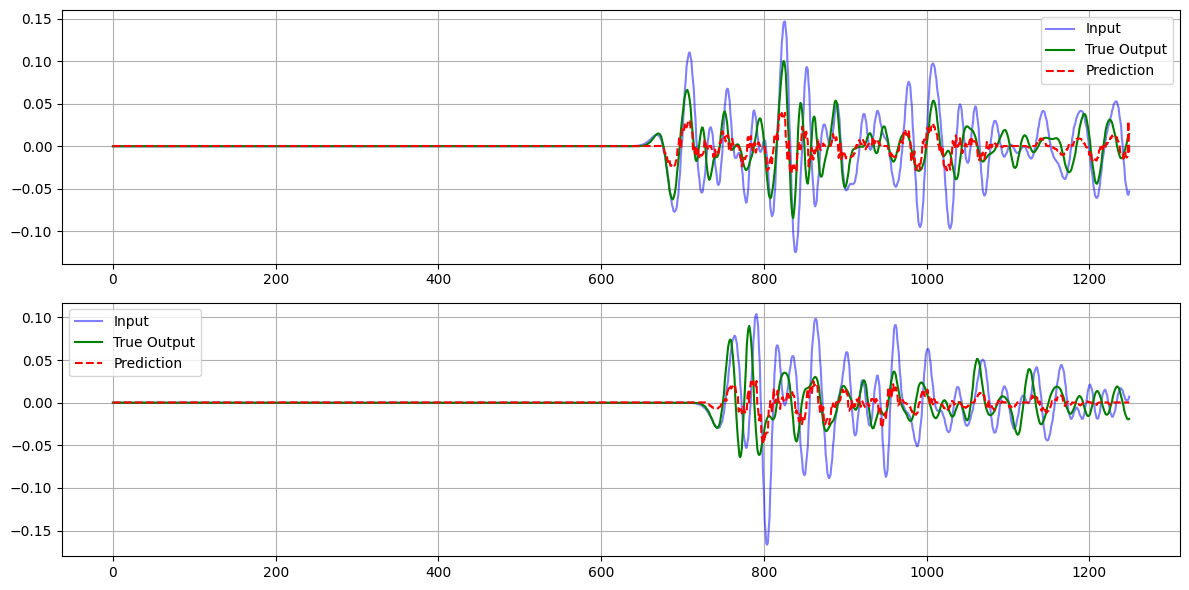

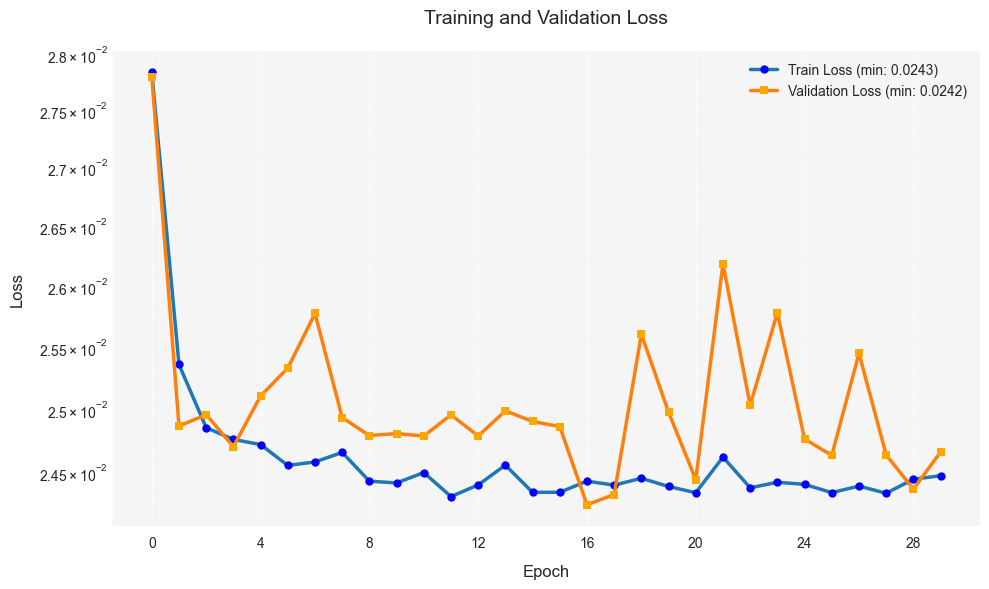

,model,val_loss,train_loss,best_val_loss,best_train_loss,epochs,sensors_num,datetime
0,dummy_model,0.045832,0.045832,0.045832,0.045832,30,2016,"05/14/2025, 02:43:43"
1,dummy_model_Fourier,0.045832,0.045832,0.045832,0.045832,30,2016,"05/14/2025, 02:43:47"
2,baseline_unet,0.024654,0.024469,0.024243,0.024306,30,2016,"05/14/2025, 02:47:40"


In [14]:
train_loss = []
val_loss = []

for epoch in tqdm(range(epochs), desc="Training"):

    batch_train_loss = []
    batch_val_loss = []

    model.train()
    for inputs, output in train_dataloader:
        inputs = inputs.float().to(device)
        output = output.float().to(device)
        predicted_output = model(inputs)
        loss = criterion(predicted_output, output)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_train_loss.append(loss.item())

    train_loss.append(np.mean(batch_train_loss))

    model.eval()
    for inputs, output in val_dataloader:
        inputs = inputs.float().to(device)
        output = output.float().to(device)

        predicted_output = model(inputs)
        loss = criterion(predicted_output, output)

        batch_val_loss.append(loss.item())

    val_loss.append(np.mean(batch_val_loss)) 

    #print(f'epoch {epoch}, train_loss {np.mean(batch_train_loss)}, val_loss {np.mean(batch_val_loss)}')
plot_predictions(model, val_dataloader, device, num_samples=2)

plot_teaching(train_loss, val_loss, len(train_loss))
new_row = [model_name, np.mean(batch_val_loss), np.mean(batch_train_loss), min(val_loss), min(train_loss), epochs, selected_sensors_num, datetime.datetime.now().strftime("%m/%d/%Y, %H:%M:%S")]
model_comparison = pd.concat([model_comparison, pd.DataFrame([new_row], columns=model_comparison.columns)], ignore_index=True)
styled = model_comparison.style.apply(highlight_rows, args=(model_name,), axis=1)
display(styled)
# print('\nFinal Metrics:')
# print(f'Best Train Loss: {min(train_loss):.4f}')
# print(f'Best Val Loss: {min(val_loss):.4f}')


### baseline + FTH_dataset (dist to impact)

Добавляем к бейзлайну учёт расстояний до сенсора. Для этого используем новый класс `FTH_dataset.MicroseismDataset`

Training:   0%|          | 0/30 [00:00<?, ?it/s]

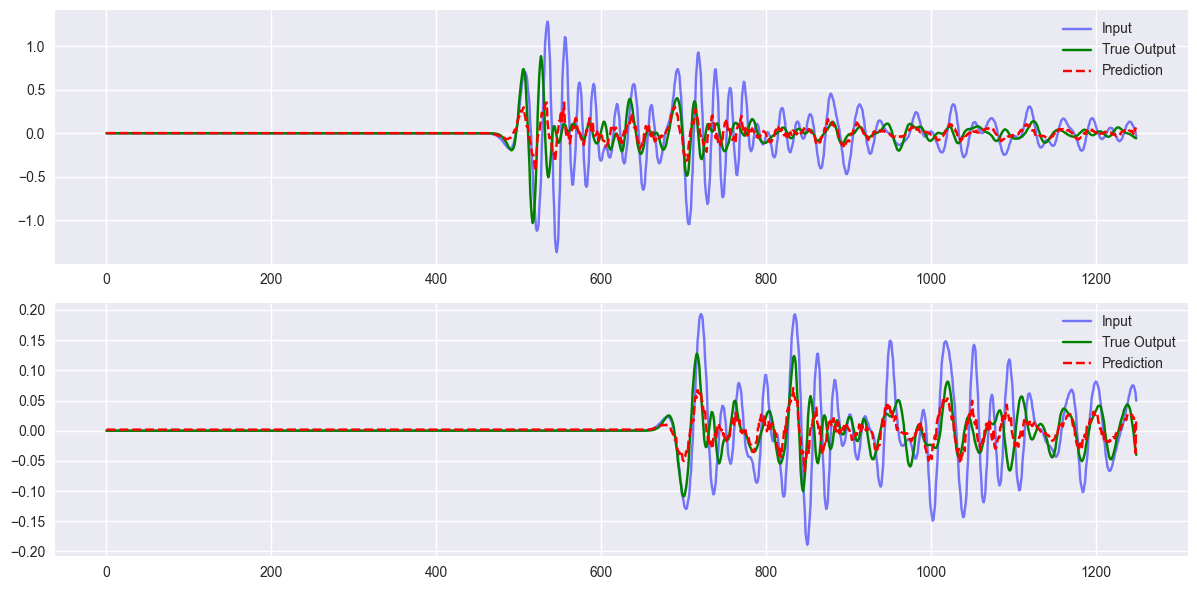

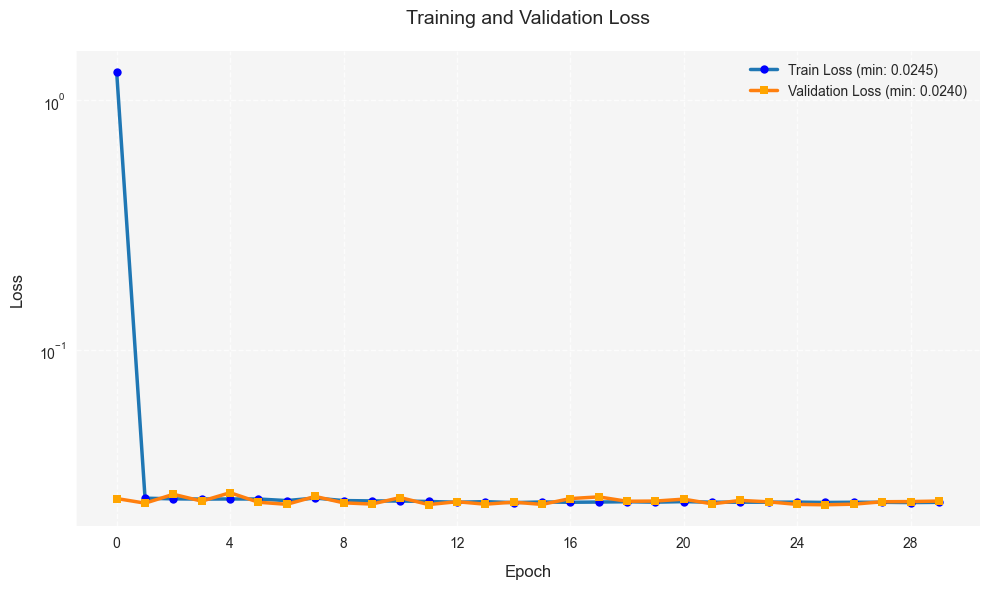

,model,val_loss,train_loss,best_val_loss,best_train_loss,epochs,sensors_num,datetime
0,dummy_model,0.045832,0.045832,0.045832,0.045832,30,2016,"05/14/2025, 02:43:43"
1,dummy_model_Fourier,0.045832,0.045832,0.045832,0.045832,30,2016,"05/14/2025, 02:43:47"
2,baseline_unet,0.024654,0.024469,0.024243,0.024306,30,2016,"05/14/2025, 02:47:40"
3,baseline_unet+dist to impact,0.024821,0.024536,0.023988,0.024468,30,2016,"05/14/2025, 02:56:44"


In [15]:
data = FTH_dataset.MicroseismDataset(input_batch=file_path_14,
                         output_batch=file_path_9,
                         selected_sensors_names=sensors_names[:selected_sensors_num],
                         number_sources_points = num_sources_points,
                         sensors_names=sensors_names,
                         distances = df,
                         channels=channels)

model_comparison, model = prapere_and_train_model('baseline_unet+dist to impact', data, FTH.unet.FTHUNet, model_comparison)


### SimpleModel

Простая свёрточная модель без skip-coonnections, но с учётом расстояний от удара до сенсора.

Training:   0%|          | 0/30 [00:00<?, ?it/s]

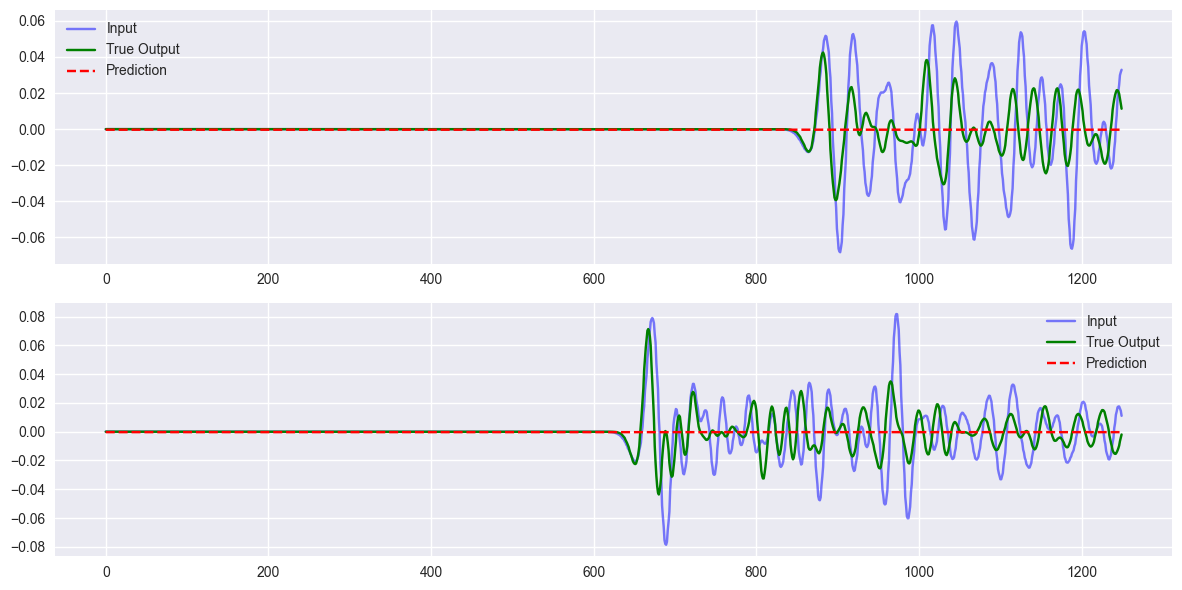

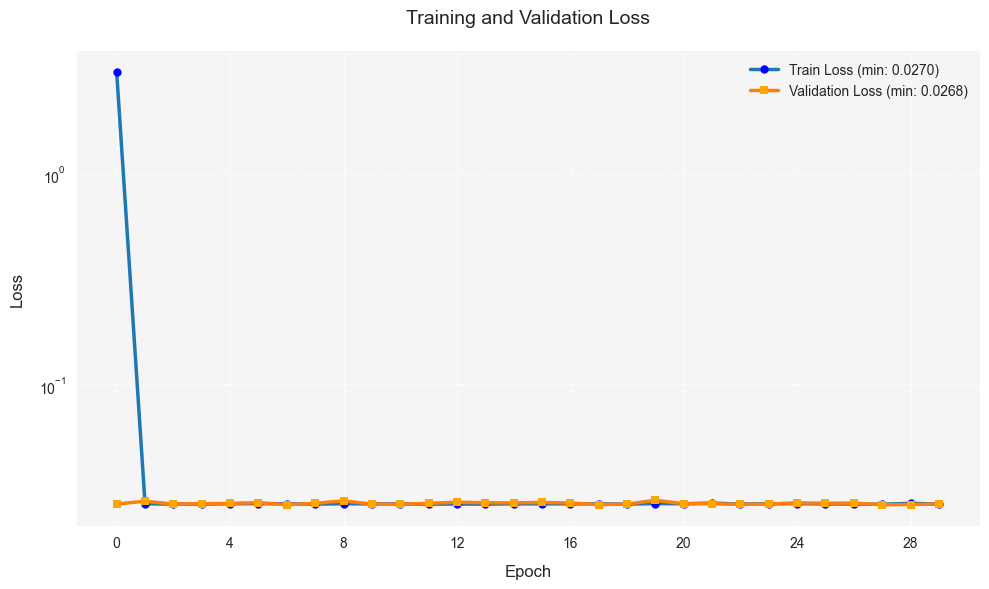

,model,val_loss,train_loss,best_val_loss,best_train_loss,epochs,sensors_num,datetime
0,dummy_model,0.045832,0.045832,0.045832,0.045832,30,2016,"05/14/2025, 02:43:43"
1,dummy_model_Fourier,0.045832,0.045832,0.045832,0.045832,30,2016,"05/14/2025, 02:43:47"
2,baseline_unet,0.024654,0.024469,0.024243,0.024306,30,2016,"05/14/2025, 02:47:40"
3,baseline_unet+dist to impact,0.024821,0.024536,0.023988,0.024468,30,2016,"05/14/2025, 02:56:44"
4,SimpleModel+dist to impact,0.027044,0.027040,0.026842,0.026992,30,2016,"05/14/2025, 03:06:13"


In [16]:
data = FTH_dataset.MicroseismDataset(input_batch=file_path_14,
                         output_batch=file_path_9,
                         selected_sensors_names=sensors_names[:selected_sensors_num],
                         number_sources_points = num_sources_points,
                         sensors_names=sensors_names,
                         distances = df,
                         channels=channels)

model_comparison, model = prapere_and_train_model('SimpleModel+dist to impact', data, FTH.SimpleModel.SimpleModel, model_comparison)

### CNN_LSTM + фильтрация по частотe

Сложная модель - сочетание CNN, LSTM и фильтрации по частоте. 30 эпох для такой модели мало

In [17]:
model_name = 'CNN_LSTM'
data = FTH_dataset.MicroseismDataset(input_batch=file_path_14,
                         output_batch=file_path_9,
                         selected_sensors_names=sensors_names[:selected_sensors_num],
                         number_sources_points = num_sources_points,
                         sensors_names=sensors_names,
                         distances = df,
                         channels=channels)


Training:   0%|          | 0/30 [00:00<?, ?it/s]

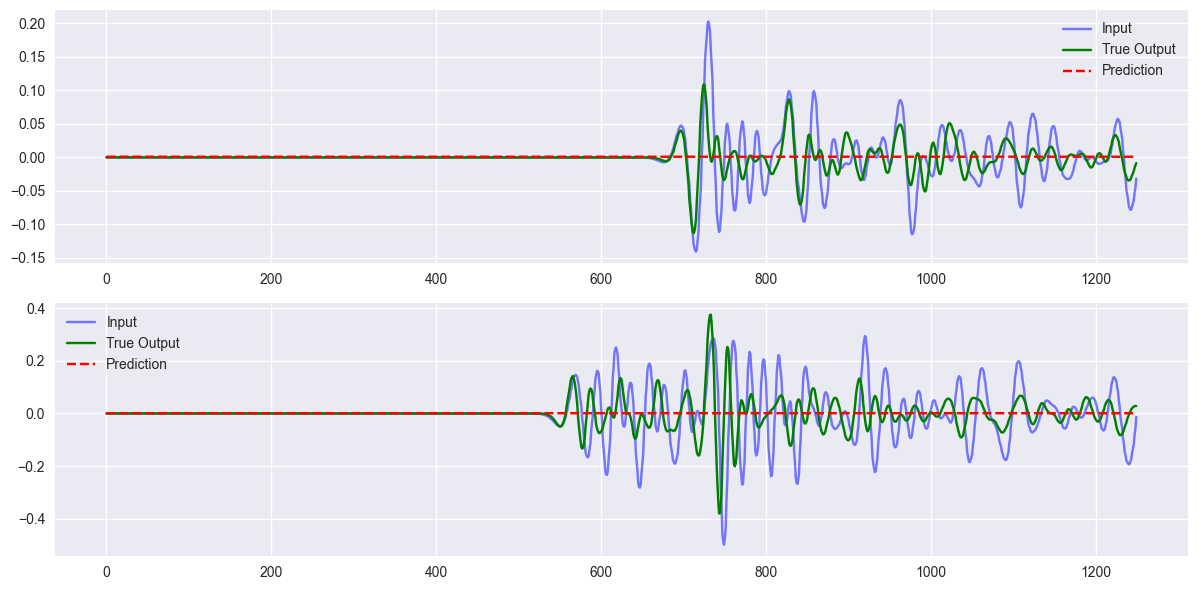

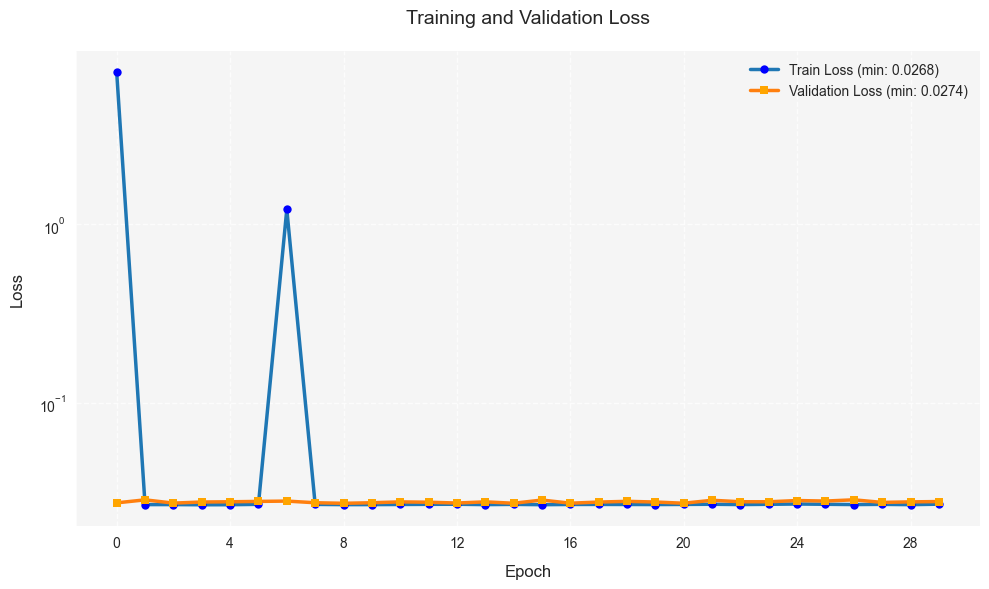

,model,val_loss,train_loss,best_val_loss,best_train_loss,epochs,sensors_num,datetime
0,dummy_model,0.045832,0.045832,0.045832,0.045832,30,2016,"05/14/2025, 02:43:43"
1,dummy_model_Fourier,0.045832,0.045832,0.045832,0.045832,30,2016,"05/14/2025, 02:43:47"
2,baseline_unet,0.024654,0.024469,0.024243,0.024306,30,2016,"05/14/2025, 02:47:40"
3,baseline_unet+dist to impact,0.024821,0.024536,0.023988,0.024468,30,2016,"05/14/2025, 02:56:44"
4,SimpleModel+dist to impact,0.027044,0.027040,0.026842,0.026992,30,2016,"05/14/2025, 03:06:13"
5,CNN_LSTM,0.027984,0.027051,0.027364,0.026845,30,2016,"05/14/2025, 03:16:53"


In [18]:
train_size = int(train_fraction * len(data))
val_size = len(data) - train_size
train_data, val_data = random_split(data, [train_size, val_size])

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = FTH.FFCNN_LSTM.FFCNN_LSTM(
        input_channels=1,
        hidden_dim=64,
        output_channels=1,
        freq_threshold=60  # Ваша частота V
).to(device)

criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


train_loss = []
val_loss = []
for epoch in tqdm(range(epochs), desc='Training'):
    model.train()
    batch_train_loss = []
    for inputs, output, distances in train_dataloader:
        inputs = inputs.float().to(device)
        output = output.float().to(device)
        distances = distances.float().to(device)
        
        predicted_output = model(inputs, distances)
        loss = criterion(predicted_output, output)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        batch_train_loss.append(loss.item())
    
    train_loss.append(np.mean(batch_train_loss))
    
    # Validation
    model.eval()
    batch_val_loss = []
    with torch.no_grad():
        for inputs, output, distances in val_dataloader:
            inputs = inputs.float().to(device)
            output = output.float().to(device)
            distances = distances.float().to(device)
            
            predicted_output = model(inputs, distances)
            loss = criterion(predicted_output, output)
            batch_val_loss.append(loss.item())
    
    val_loss.append(np.mean(batch_val_loss))
    
    #print(f"Epoch {epoch+1}: Train Loss: {train_loss[-1]:.4f}, Val Loss: {val_loss[-1]:.4f}")

plot_predictions(model, val_dataloader, device, num_samples=2)

plot_teaching(train_loss, val_loss, len(train_loss))
new_row = [model_name, np.mean(batch_val_loss), np.mean(batch_train_loss), min(val_loss), min(train_loss), epochs, selected_sensors_num, datetime.datetime.now().strftime("%m/%d/%Y, %H:%M:%S")]
model_comparison = pd.concat([model_comparison, pd.DataFrame([new_row], columns=model_comparison.columns)], ignore_index=True)
styled = model_comparison.style.apply(highlight_rows, args=(model_name,), axis=1)
display(styled)

### GNN (graph)

Модель базирующаяся на свёртках на графах

In [ ]:
model_name = 'GNN'

best_val_loss = float('inf')
best_train_loss = float('inf')
early_stop_patience = 10
no_improve = 0


data = FTH.GNN.MicroseismGraphDataset(
    input_batch=file_path_14,
    output_batch=file_path_9,
    selected_sensors_names=sensors_names[:selected_sensors_num],
    number_sources_points=num_sources_points,
    sensors_names=sensors_names,
    channels=channels,
    distances=df,
    connection_radius=100.0
)

train_size = int(train_fraction * len(data))
val_size = len(data) - train_size
train_data, val_data = random_split(data, [train_size, val_size])

# проверяем гипотезу про количество точек в валидационной выборке
# train_data = FTH.GNN.MicroseismGraphDataset(
#     input_batch=file_path_14,
#     output_batch=file_path_9,
#     selected_sensors_names=sensors_names[:selected_sensors_num],
#     number_sources_points=[1],
#     sensors_names=sensors_names,
#     channels=channels,
#     distances=df,
#     connection_radius=100.0
# )

# val_data = FTH.GNN.MicroseismGraphDataset(
#     input_batch=file_path_14,
#     output_batch=file_path_9,
#     selected_sensors_names=sensors_names[:selected_sensors_num],
#     number_sources_points=[0],
#     sensors_names=sensors_names,
#     channels=channels,
#     distances=df,
#     connection_radius=100.0
# )


train_dataloader = geoDataLoader(train_data, batch_size=batch_size, shuffle=True)
val_dataloader = geoDataLoader(val_data, batch_size=batch_size, shuffle=True)

model = FTH.GNN.DistanceAwareGNN(
    num_features=data[0].x.shape[1],  # Time steps as features
    hidden_dim=64,
    output_dim=data[0].y.shape[1]
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)

# Modified training functions
def train_one_epoch(model, loader, optimizer):
    model.train()
    total_loss = 0
    for batch in loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch)  # Now passing the entire batch object
        loss = criterion(out, batch.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch.num_graphs
    return total_loss / len(loader.dataset)

def validate(model, loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            out = model(batch) 
            loss = criterion(out, batch.y)
            total_loss += loss.item() * batch.num_graphs
    return total_loss / len(loader.dataset)


In [ ]:
def GNN_plot_predictions(model, val_dataloader, device, num_samples=2):
    model.eval()
    fig, axes = plt.subplots(num_samples, 1, figsize=(12, 4*num_samples))
    if num_samples == 1:
        axes = [axes]
    
    samples_collected = 0
    with torch.no_grad():
        for batch in val_dataloader:
            if samples_collected >= num_samples:
                break
                
            batch = batch.to(device)
            preds = model(batch).cpu().numpy()
            targets = batch.y.cpu().numpy()
            
            # Handle both node-level and graph-level predictions
            if preds.ndim == 1 or preds.shape[0] == 1:  # Graph-level predictions
                for i in range(min(num_samples - samples_collected, preds.size)):
                    ax = axes[samples_collected]
                    ax.scatter(targets[i], preds[i], c='r', alpha=0.5)
                    ax.plot([targets.min(), targets.max()], 
                           [targets.min(), targets.max()], 'k--')
                    ax.set_xlabel('True Values')
                    ax.set_ylabel('Predictions')
                    samples_collected += 1
            else:  # Node-level predictions
                for i in range(min(num_samples - samples_collected, preds.shape[0])):
                    ax = axes[samples_collected]
                    ax.plot(targets[i], 'b-', label='True')
                    ax.plot(preds[i], 'r--', label='Predicted')
                    ax.legend()
                    ax.grid(True)
                    samples_collected += 1
    
    plt.tight_layout()
    plt.show()

Training:   0%|          | 0/30 [00:00<?, ?it/s]

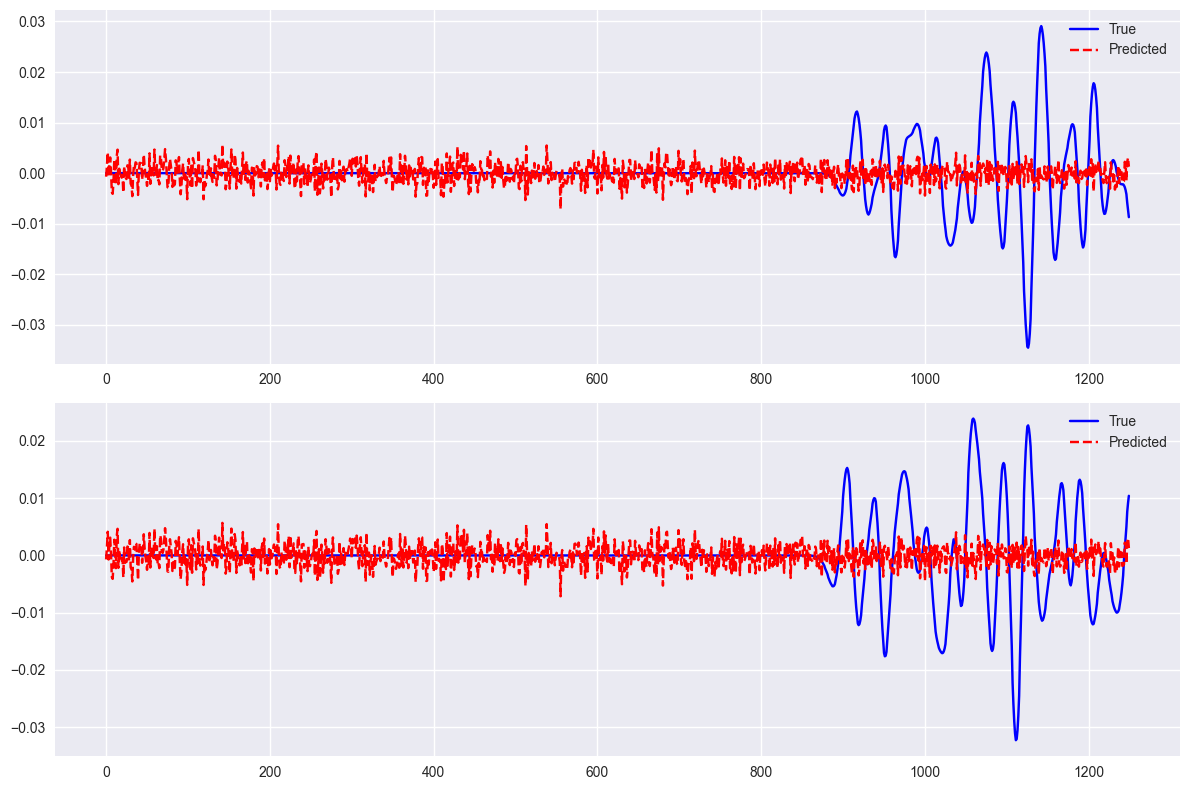

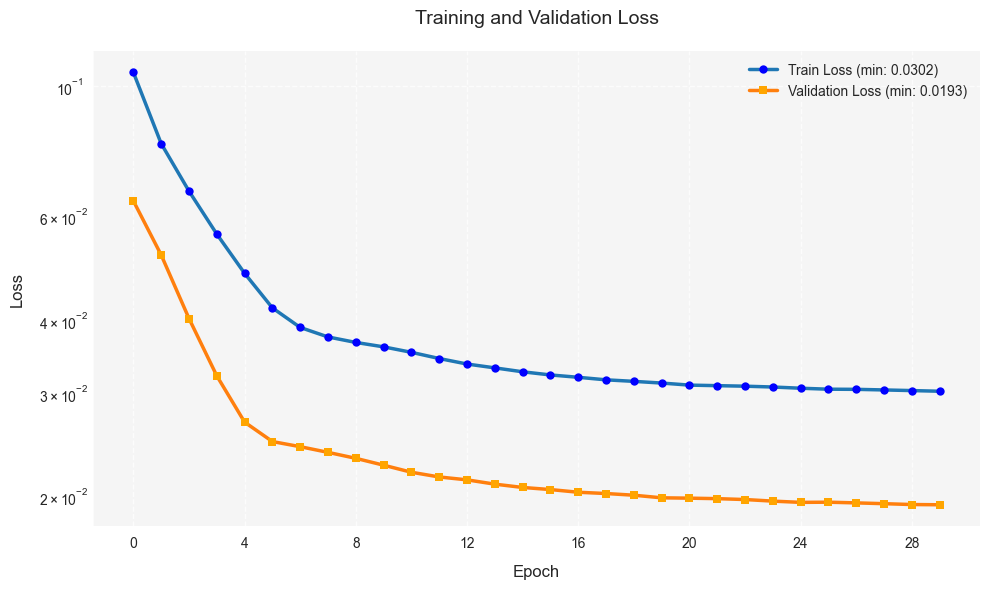

,model,val_loss,train_loss,best_val_loss,best_train_loss,epochs,sensors_num,datetime
0,dummy_model,0.045832,0.045832,0.045832,0.045832,30,2016,"05/14/2025, 02:43:43"
1,dummy_model_Fourier,0.045832,0.045832,0.045832,0.045832,30,2016,"05/14/2025, 02:43:47"
2,baseline_unet,0.024654,0.024469,0.024243,0.024306,30,2016,"05/14/2025, 02:47:40"
3,baseline_unet+dist to impact,0.024821,0.024536,0.023988,0.024468,30,2016,"05/14/2025, 02:56:44"
4,SimpleModel+dist to impact,0.027044,0.027040,0.026842,0.026992,30,2016,"05/14/2025, 03:06:13"
5,CNN_LSTM,0.027984,0.027051,0.027364,0.026845,30,2016,"05/14/2025, 03:16:53"
6,GNN_Z,0.024495,0.039251,0.019296,0.030151,30,2016,"05/14/2025, 03:20:14"


In [21]:
train_losses = []
val_losses = []

for epoch in tqdm(range(epochs), desc="Training"):
    train_loss = train_one_epoch(model, train_dataloader, optimizer)
    val_loss = validate(model, val_dataloader)
    scheduler.step(val_loss)
    
    # Track best losses
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_train_loss = train_loss
        no_improve = 0
        # Save best model
    else:
        no_improve += 1
    
    # Store losses
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    # print(f'Epoch {epoch+1}/{epochs}: '
    #       f'Train Loss: {train_loss:.4f}, '
    #       f'Val Loss: {val_loss:.4f}, '
    #       f'Best Val: {best_val_loss:.4f}')
    
    # Early stopping
    if no_improve >= early_stop_patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

GNN_plot_predictions(model, val_dataloader, device, num_samples=2)

#torch.save(model.state_dict(), f'{model_name}_{epoch+1}_{epochs}.pth')
new_row = [model_name, np.mean(val_losses), np.mean(train_losses), min(val_losses), min(train_losses), epochs, selected_sensors_num, datetime.datetime.now().strftime("%m/%d/%Y, %H:%M:%S")]
model_comparison = pd.concat([model_comparison, pd.DataFrame([new_row], columns=model_comparison.columns)], ignore_index=True)


plot_teaching(train_losses, val_losses, len(train_losses))
styled = model_comparison.style.apply(highlight_rows, args=(model_name,), axis=1)
display(styled)


In [22]:
#plot_teaching(train_losses[50:], val_losses[50:], len(train_losses))

### ModUnet

Unet с большим окном свёртки и большим числом блоков свёрток между skip-connections. Также для большей резистентности к переобучению добавлены BatchNorm'ы  
Учитываются только расстояния до сенсоров от точки удара

Training:   0%|          | 0/30 [00:00<?, ?it/s]

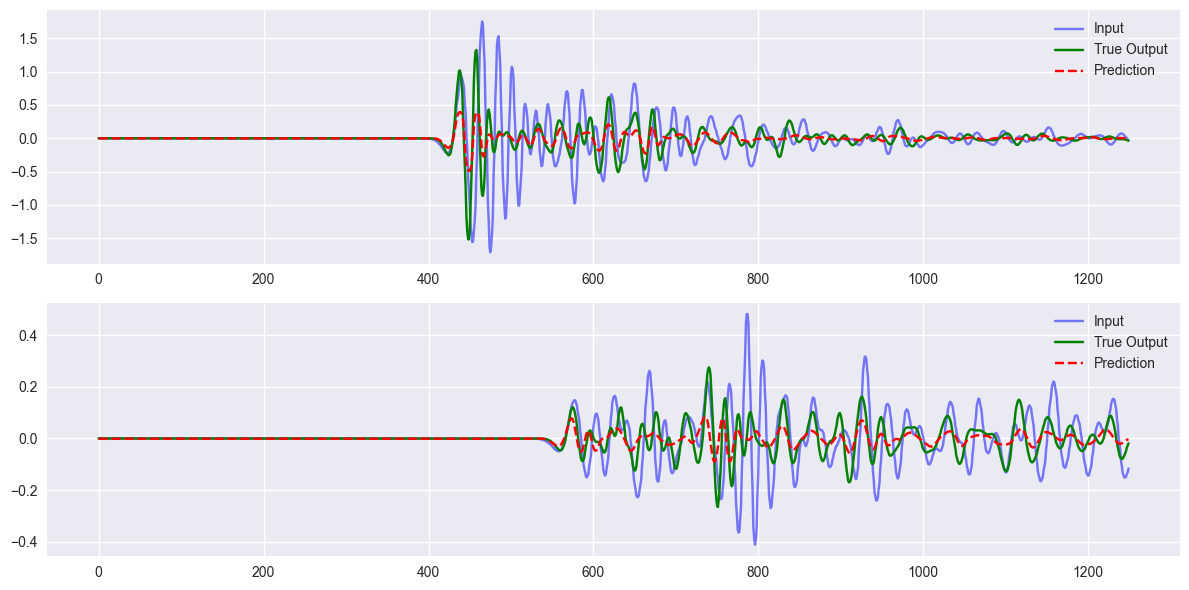

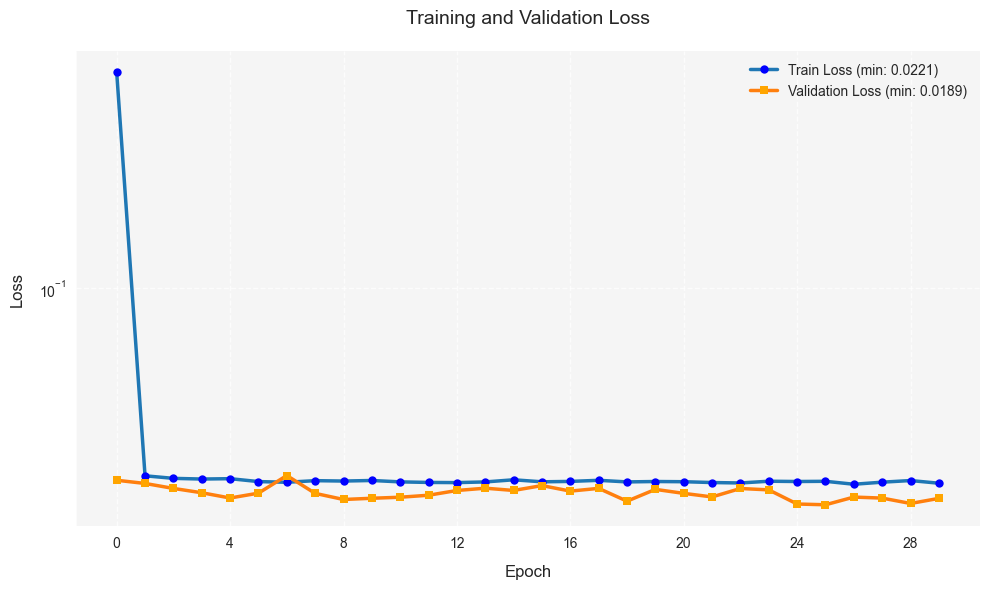

,model,val_loss,train_loss,best_val_loss,best_train_loss,epochs,sensors_num,datetime
0,dummy_model,0.045832,0.045832,0.045832,0.045832,30,2016,"05/14/2025, 02:43:43"
1,dummy_model_Fourier,0.045832,0.045832,0.045832,0.045832,30,2016,"05/14/2025, 02:43:47"
2,baseline_unet,0.024654,0.024469,0.024243,0.024306,30,2016,"05/14/2025, 02:47:40"
3,baseline_unet+dist to impact,0.024821,0.024536,0.023988,0.024468,30,2016,"05/14/2025, 02:56:44"
4,SimpleModel+dist to impact,0.027044,0.027040,0.026842,0.026992,30,2016,"05/14/2025, 03:06:13"
5,CNN_LSTM,0.027984,0.027051,0.027364,0.026845,30,2016,"05/14/2025, 03:16:53"
6,GNN_Z,0.024495,0.039251,0.019296,0.030151,30,2016,"05/14/2025, 03:20:14"
7,ModUnet,0.019860,0.022311,0.018911,0.022136,30,2016,"05/14/2025, 03:29:46"


In [23]:
data = FTH_dataset.MicroseismDataset(input_batch=file_path_14,
                         output_batch=file_path_9,
                         selected_sensors_names=sensors_names[:selected_sensors_num],
                         number_sources_points = num_sources_points,
                         sensors_names=sensors_names,
                         distances = df,
                         channels=channels)

model_comparison, model = prapere_and_train_model('ModUnet', data, FTH.ModUnet.ModUnet, model_comparison)

### CoordModNet

Модифицированная предыдущая модель, которая учитывает не только расстояния, но и положение сенсоров.

Training:   0%|          | 0/30 [00:00<?, ?it/s]

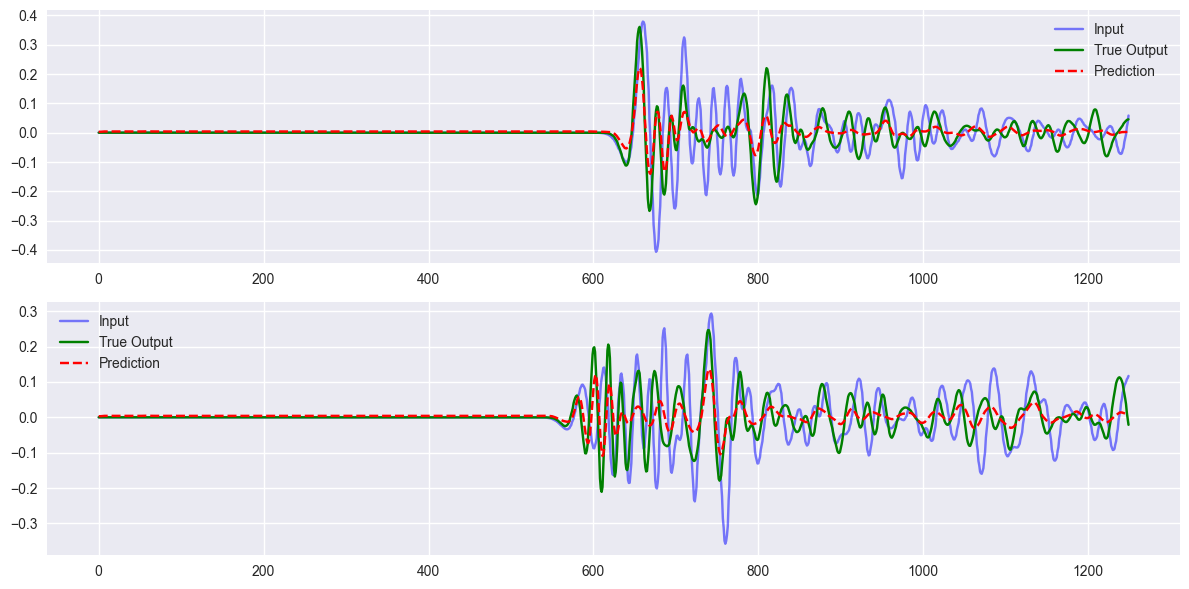

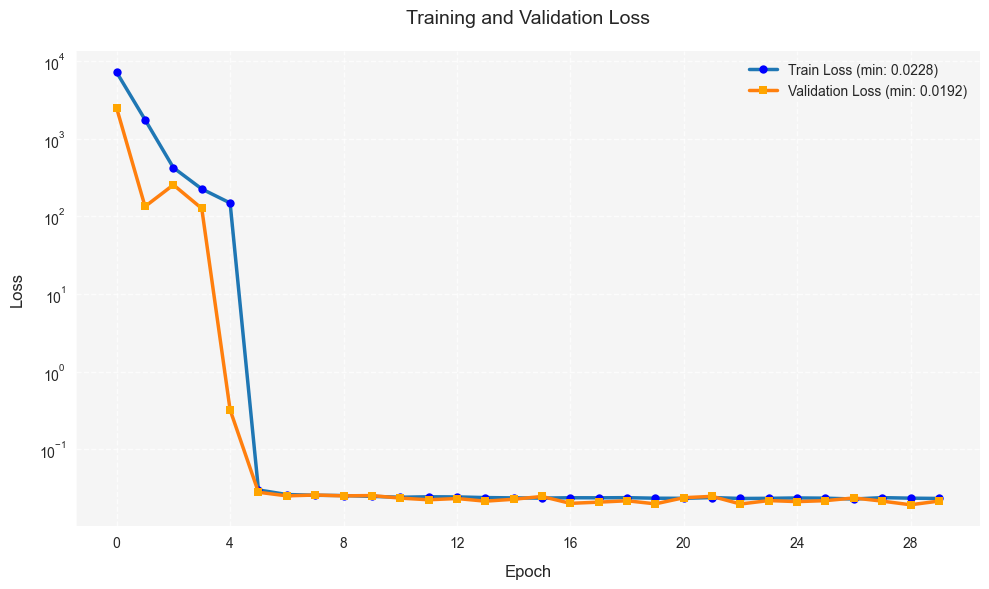

,model,val_loss,train_loss,best_val_loss,best_train_loss,epochs,sensors_num,datetime
0,dummy_model,0.045832,0.045832,0.045832,0.045832,30,2016,"05/14/2025, 02:43:43"
1,dummy_model_Fourier,0.045832,0.045832,0.045832,0.045832,30,2016,"05/14/2025, 02:43:47"
2,baseline_unet,0.024654,0.024469,0.024243,0.024306,30,2016,"05/14/2025, 02:47:40"
3,baseline_unet+dist to impact,0.024821,0.024536,0.023988,0.024468,30,2016,"05/14/2025, 02:56:44"
4,SimpleModel+dist to impact,0.027044,0.027040,0.026842,0.026992,30,2016,"05/14/2025, 03:06:13"
5,CNN_LSTM,0.027984,0.027051,0.027364,0.026845,30,2016,"05/14/2025, 03:16:53"
6,GNN_Z,0.024495,0.039251,0.019296,0.030151,30,2016,"05/14/2025, 03:20:14"
7,ModUnet,0.019860,0.022311,0.018911,0.022136,30,2016,"05/14/2025, 03:29:46"
8,CoordsModUnet,0.021398,0.023143,0.019190,0.022765,30,2016,"05/14/2025, 03:53:46"


In [24]:
model_name = 'CoordsModUnet'
data = FTH_coords_dataset.FTHCoordsDataset(input_batch=file_path_14,
                         output_batch=file_path_9,
                         selected_sensors_names=sensors_names[:selected_sensors_num],
                         number_sources_points = num_sources_points,
                         sensors_names=sensors_names,
                         distances_df = df,
                         channels=channels)
model_comparison, model = prapere_and_train_model(model_name, data, FTH.CoordsModUnet.CoordsModUnet, model_comparison)

# Resulting table

In [25]:
display(model_comparison.sort_values(by='val_loss'))
model_comparison.to_csv(model_comparison_path, index=False)

,model,val_loss,train_loss,best_val_loss,best_train_loss,epochs,sensors_num,datetime
7,ModUnet,0.019860,0.022311,0.018911,0.022136,30,2016,"05/14/2025, 03:29:46"
8,CoordsModUnet,0.021398,0.023143,0.019190,0.022765,30,2016,"05/14/2025, 03:53:46"
6,GNN_Z,0.024495,0.039251,0.019296,0.030151,30,2016,"05/14/2025, 03:20:14"
2,baseline_unet,0.024654,0.024469,0.024243,0.024306,30,2016,"05/14/2025, 02:47:40"
3,baseline_unet+dist to impact,0.024821,0.024536,0.023988,0.024468,30,2016,"05/14/2025, 02:56:44"
4,SimpleModel+dist to impact,0.027044,0.027040,0.026842,0.026992,30,2016,"05/14/2025, 03:06:13"
5,CNN_LSTM,0.027984,0.027051,0.027364,0.026845,30,2016,"05/14/2025, 03:16:53"
0,dummy_model,0.045832,0.045832,0.045832,0.045832,30,2016,"05/14/2025, 02:43:43"
1,dummy_model_Fourier,0.045832,0.045832,0.045832,0.045832,30,2016,"05/14/2025, 02:43:47"
